In [12]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import scipy.optimize as sciopt
import scipy.stats as stats
import pandas as pd

data = pd.read_csv('../results/dose_response_params_09252023.csv')
g_drugless = data['g_drugless']
ic50_est = data['ic50']
mut_list = data['n_mut']

gr_lib = pd.read_csv('../results/gr_lib.csv',index_col=0)
gr_err_lib = pd.read_csv('../results/gr_err_lib.csv',index_col=0)

def int_to_binary(num,n_genotype=16):
    """
    Converts an integer to binary representation with the number of 
    digits equal to the number of alleles in the model.

    Parameters
    ----------
    num : int
        Number to be converted.

    Returns
    -------
    str
        Binary representation.

    """
    pad = int(np.log2(n_genotype))
    return bin(num)[2:].zfill(pad)

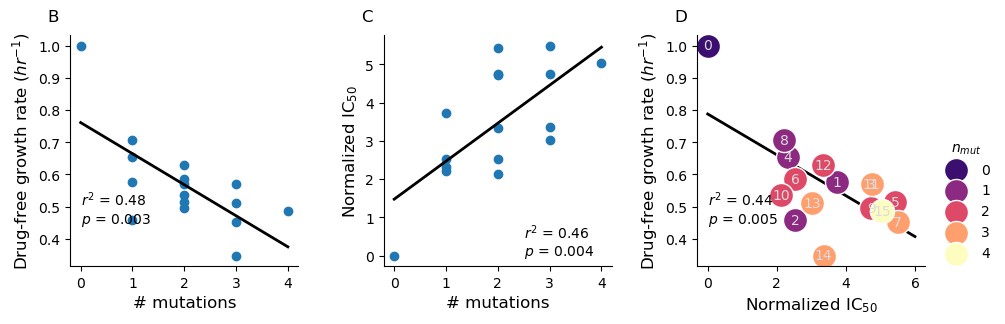

In [13]:
fig,ax_list = plt.subplots(ncols=3,figsize=(10,3))

g_drugless = np.array(g_drugless)
g_norm = g_drugless/g_drugless[0]

ax = ax_list[0]

ax.plot(mut_list,g_norm,'o')

res = stats.linregress(mut_list,g_norm)

x = np.arange(5)
y = res.slope*x + res.intercept

ax.plot(x,y,color='k',linewidth=2)

ax.set_xticks([0,1,2,3,4])

ax.set_xlabel('# mutations',fontsize=12)
ax.set_ylabel('Drug-free growth rate ($hr^{-1}$)',fontsize=12)
ax.tick_params(axis='both', labelsize=10)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ann = '$r^2$ = ' + str(round(res.rvalue**2,2)) + '\n$p$ = ' + str(round(res.pvalue,3))
ax.annotate(ann,(0,0.45),fontsize=10)

ax = ax_list[1]

ic50_norm = ic50_est - ic50_est[0]

ax.plot(mut_list,ic50_norm,'o')

res = stats.linregress(mut_list,ic50_norm)

x = np.arange(5)
y = res.slope*x + res.intercept

ax.plot(x,y,color='k',linewidth=2)

ax.set_xticks([0,1,2,3,4])

ax.set_xlabel('# mutations',fontsize=12)
ax.set_ylabel('Normalized IC$_{50}$',fontsize=12)
ax.tick_params(axis='both', labelsize=10)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ann = '$r^2$ = ' + str(round(res.rvalue**2,2)) + '\n$p$ = ' + str(round(res.pvalue,3))
ax.annotate(ann,(2.5,0),fontsize=10)

ax = ax_list[2]

cmap = cm.get_cmap('magma',6)
cmap = cmap.colors

mut_v_gr = [[],[],[],[],[]]

ic50_norm = ic50_est - ic50_est[0]

for key in data.index:

    ic50 = ic50_norm[int(key)]
    g = g_norm[int(key)]

    # key_bin = int(key)

    num = mut_list[int(key)]

    mut_v_gr[num].append(g_drugless)

    ax.scatter(ic50,g,marker='o',s=300,facecolor=cmap[num+1],
                edgecolors='w',label=int(num))
    # ax4.annotate(key,(ic50-0.15,g_drugless-0.001),fontsize=12)
    ax.annotate(key,(ic50,g),fontsize=10,ha='center',va='center',color='gainsboro')
    

# ax.set_ylim(0.06,0.115)
# ax.set_xlim(-3,4)
ax.set_ylabel('Drug-free growth rate ($hr^{-1}$)',fontsize=12)
ax.set_xlabel('Normalized IC$_{50}$',fontsize=12)
ax.tick_params(axis='both', labelsize=10)

handles, labels = ax.get_legend_handles_labels()

unique_labels = sorted(set(labels))
labels = np.array(labels)
unique_handles = []

for lab in unique_labels:
    indx = np.argwhere(labels==lab)
    indx = indx[0][0]
    unique_handles.append(handles[indx])

ax.legend(unique_handles,unique_labels,loc = (1.05,0),frameon=False,
             fontsize=10,title='$n_{mut}$')

res = stats.linregress(ic50_norm,g_norm)

xfit = np.arange(0,7)
yfit = res.slope*xfit + res.intercept

ax.plot(xfit,yfit,color='k',linewidth=2,zorder=0)

ann = '$r^2$ = ' + str(round(res.rvalue**2,2)) + '\n$p$ = ' + str(round(res.pvalue,3))
ax.annotate(ann,(0,0.45),fontsize=10)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

labels = ['B','C','D']

indx = 0
for ax in ax_list:
    pos = ax.get_position()
    pos.x0 = pos.x0 + 0.04*indx
    pos.x1 = pos.x1 + 0.04*indx
    ax.set_position(pos)

    ax.annotate(labels[indx],(-0.1,1.06),fontsize=12,xycoords='axes fraction')

    indx += 1

# fig.tight_layout()
fig.savefig('../figures/gr_vs_ic50_regression.pdf',bbox_inches='tight')
fig.savefig('../figures/gr_vs_ic50_regression.png',bbox_inches='tight',dpi=300)

/var/folders/zc/70qypfn92xg4qzzd0ldt5ks80000gn/T/ipykernel_81378/777457191.py:8: RuntimeWarning: overflow encountered in exp
  y.append(gmax/(1+np.exp((ic_50-np.log10(c))/hc)))


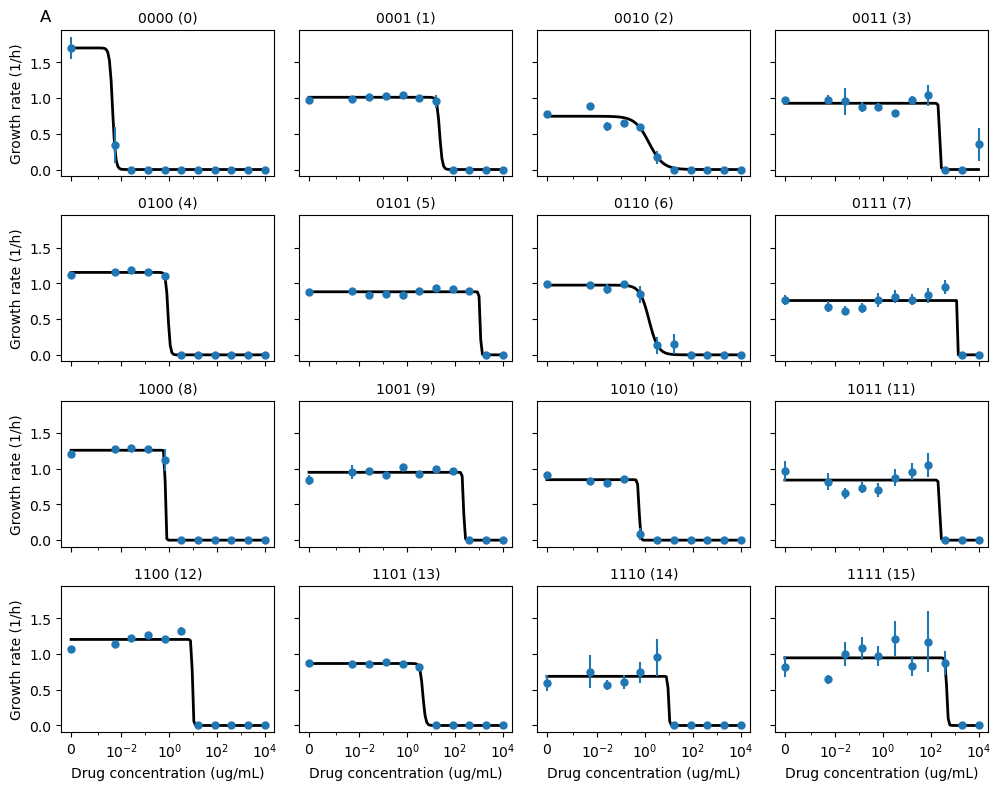

In [14]:
def hill_fn(conc,gmax, hc, ic_50):
    y = []
    gmin = 0
    for c in conc:
        if c == 0:
            y.append(gmax)
        else:
            y.append(gmax/(1+np.exp((ic_50-np.log10(c))/hc)))
    return y

fig,ax_list = plt.subplots(nrows=4,ncols=4,figsize=(10,8),sharex=True,sharey=True)
ax_list_matrix = ax_list
ax_list = ax_list.flatten()

g_drugless = np.zeros(16)

mic_est = []

seascape_lib = {}

# drug_conc = np.array(gr_lib['drug_conc'])
drug_conc = list(gr_lib['drug_conc'])
drug_conc = [float(i) for i in drug_conc if i != 'control']

for key in np.arange(16):
    y = np.array(gr_lib[str(key)])
    y = y[0:-1]
    x = np.argwhere(y<0.5)
    mic = drug_conc[x[-1][0]]
    mic_est.append(mic)

for i in range(16):
    
    gr_v_dc = np.array(gr_lib[str(i)])
    gr_v_dc_err = np.array(gr_err_lib[str(i)])

    ic50_est = np.log10(np.array(mic_est[i]).astype(float))

    p0 = [gr_v_dc[-2],-0.1,ic50_est]
    # bounds = [[gr_v_dc[-2]-0.1,-10,ic50_est-2],[gr_v_dc[-2]+0.1,0,ic50_est+2]]
    bounds = [[0,-10,ic50_est-2],[2,0,ic50_est+2]]

    gr_v_dc_err_t = np.array(gr_v_dc_err) + 1

    popt,pcov = sciopt.curve_fit(hill_fn,drug_conc,gr_v_dc[0:-1],
                                p0=p0,maxfev=100000,bounds=bounds,
                                sigma=gr_v_dc_err_t[0:-1],absolute_sigma=False)
    
    xfit = np.logspace(-3,4,100)
    xfit = np.concatenate(([0],xfit))

    yfit = hill_fn(xfit,*popt)

    ax = ax_list[i]
    ax.plot(xfit,yfit,color='k',linewidth=2)

    ax.errorbar(drug_conc,gr_v_dc[0:-1],yerr=gr_v_dc_err[0:-1],
                fmt='o',markersize=5)
    
    ax.set_xscale('symlog',linthresh=10**-3)
    ax.set_title(int_to_binary(i) + ' (' + str(i) + ')',fontsize=10)
    # ax.set_yscale('log')
    g_drugless[i] = gr_v_dc[-2]

    param_dict = {'gmax':popt[0],'hc':popt[1],'ic50':popt[2]}
    seascape_lib[i] = param_dict

ax = ax_list[-1]
ax.set_xticks([0,10**-2,1,10**2,10**4]);

for ax in ax_list_matrix[-1,:]:
    ax.set_xlabel('Drug concentration (ug/mL)')

for ax in ax_list_matrix[:,0]:
    ax.set_ylabel('Growth rate (1/h)')

ax_list_matrix[0,0].annotate('A',(-0.1,1.06),fontsize=12,xycoords='axes fraction')

fig.tight_layout()

fig.savefig('../figures/dose_response_curves.pdf',bbox_inches='tight')

In [15]:
for key in seascape_lib.keys():
    
    print(seascape_lib[key]['gmax'])

1.702009223435177
1.0116273984921897
0.7460126728512606
0.9276039604874466
1.1542428009345755
0.8828861253056327
0.9762377496920666
0.7604102428839906
1.258960805752934
0.9499524057339928
0.846965980665635
0.8413912921597035
1.204905083752953
0.8677695036957205
0.6880990889576407
0.9470095681478576


In [16]:
def gen_neighbors(genotype,n_allele=4):
    mut = range(n_allele)
    neighbors = [genotype ^ (1 << m) for m in mut]

    return neighbors

diff_dict = {}
diff_dict_rel = {} # relative to the wt

ic50_diff_dict = {}

for allele in [0,1,2,3]:
    # generate each genotype contaiing the allele
    contains_allele = []
    excludes_allele = []
    for i in range(16):
        if int_to_binary(i)[3-allele] == '1':
            contains_allele.append(i)
        else:
            excludes_allele.append(i)
    
    diff = []
    ic50_diff = []
    for g in contains_allele:
        neighbors = gen_neighbors(g)
        # find the neighbors that do not contain the allele
        neighbors = [n for n in neighbors if n in excludes_allele]

        cur_fit = g_drugless[g]
        cur_ic50 = ic50_norm[g]

        neighbor_fit = g_drugless[neighbors[0]]
        neighbor_ic50 = ic50_norm[neighbors[0]]

        diff.append(cur_fit - neighbor_fit)
        ic50_diff.append(cur_ic50 - neighbor_ic50)

    diff_dict[allele] = diff
    diff_dict_rel[allele] = [g_drugless[i]-g_drugless[0] for i in contains_allele]
    ic50_diff_dict[allele] = ic50_diff
    

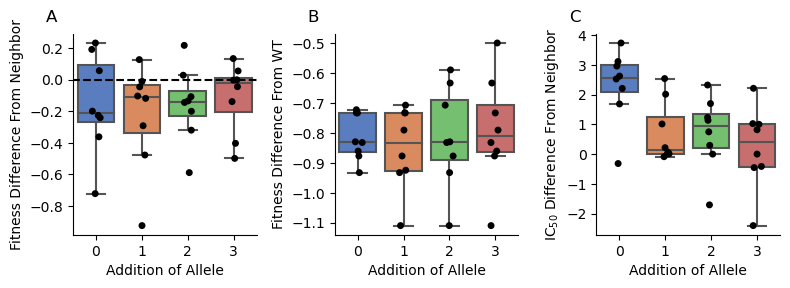

In [17]:
import seaborn as sns

fig,ax_list = plt.subplots(ncols=3,figsize=(8,3))

ax = ax_list[0]
sns.boxplot(data=pd.DataFrame(diff_dict),ax=ax,showfliers=False,palette='muted')
sns.stripplot(data=pd.DataFrame(diff_dict),ax=ax,color='k',size=5)

ax.set_ylabel('Fitness Difference From Neighbor')
ax.set_xlabel('Addition of Allele')

ax.plot([-1,4],[0,0],'k--')

ax.set_xlim(-0.5,3.5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax = ax_list[1]

sns.boxplot(data=pd.DataFrame(diff_dict_rel),ax=ax,showfliers=False,palette='muted')
sns.stripplot(data=pd.DataFrame(diff_dict_rel),ax=ax,color='k',size=5)

ax.set_ylabel('Fitness Difference From WT')
ax.set_xlabel('Addition of Allele')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax = ax_list[2]

sns.boxplot(data=pd.DataFrame(ic50_diff_dict),ax=ax,showfliers=False,palette='muted')
sns.stripplot(data=pd.DataFrame(ic50_diff_dict),ax=ax,color='k',size=5)

ax.set_ylabel('IC$_{50}$ Difference From Neighbor')
ax.set_xlabel('Addition of Allele')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

labels = ['A','B','C']
for i,ax in enumerate(ax_list):
    ax.annotate(labels[i],(-0.15,1.06),fontsize=12,xycoords='axes fraction')

fig.tight_layout()

fig.savefig('../figures/allele_fitness_diff.pdf',bbox_inches='tight')

In [18]:
# pairwise t-test for ic50 differences

for i in range(4):
    for j in range(i+1,4):
        print('Allele',i,'vs Allele',j)
        pval = stats.ttest_ind(ic50_diff_dict[i],ic50_diff_dict[j],equal_var=False).pvalue
        print('p-value:',pval)

Allele 0 vs Allele 1
p-value: 0.01406808827421402
Allele 0 vs Allele 2
p-value: 0.02063175660073684
Allele 0 vs Allele 3
p-value: 0.006479761248565582
Allele 1 vs Allele 2
p-value: 0.9910018298797653
Allele 1 vs Allele 3
p-value: 0.42778712223762305
Allele 2 vs Allele 3
p-value: 0.4640257290911525


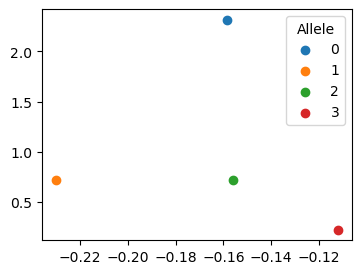

In [19]:
fig,ax = plt.subplots(figsize=(4,3))

for key in diff_dict.keys():

    diff = np.mean(diff_dict[key])
    ic_50 = np.mean(ic50_diff_dict[key])


    ax.scatter(diff,ic_50,label=key)

ax.legend(title='Allele',fontsize=10)